Original DataFrame sample:
   MedInc  AveRooms  HouseAge  MedHouseVal
0  8.3252  6.984127      41.0        4.526
1  8.3014  6.238137      21.0        3.585
2  7.2574  8.288136      52.0        3.521
3  5.6431  5.817352      52.0        3.413
4  3.8462  6.281853      52.0        3.422


Generated feature names: ['MedInc' 'AveRooms' 'MedInc AveRooms']

DataFrame with the new interaction feature column:
   MedInc  AveRooms  HouseAge  MedHouseVal  MedInc_x_AveRooms
0  8.3252  6.984127      41.0        4.526          58.144254
1  8.3014  6.238137      21.0        3.585          51.785271
2  7.2574  8.288136      52.0        3.521          60.150315
3  5.6431  5.817352      52.0        3.413          32.827897
4  3.8462  6.281853      52.0        3.422          24.161264


Correlation of features with Target (MedHouseVal):
MedHouseVal          1.000000
MedInc               0.688075
MedInc_x_AveRooms    0.555438
AveRooms             0.151948
HouseAge             0.105623
Name: MedHouseVal, dt

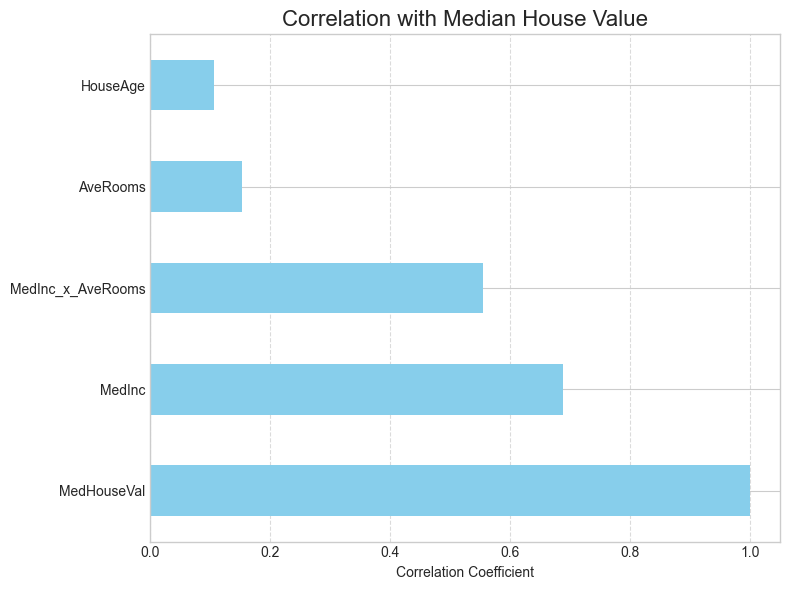

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# ---
# When to Use Interaction Features & Feature Crossing
# ---
# 1. To Capture Non-Linearity: Standard linear models can only learn linear relationships
#    (e.g., house price increases by a fixed amount for each extra room). Feature crossing
#    allows the model to learn combined effects (e.g., the value of an extra room might be
#    MUCH higher in a high-income neighborhood).
#
# 2. For Models that Can't Do it Themselves: Tree-based models (like Random Forests or
#    Gradient Boosting) can implicitly find feature interactions. However, linear models
#    (Linear Regression, Logistic Regression, SVMs with linear kernels) cannot. Creating
#    these features manually significantly boosts their performance.
#
# Data Requirements:
# - The technique works on any numerical or categorical features.
# - For continuous numerical features, you can either multiply them directly or first
#   discretize (bin) them into categories and then cross the categories.
# - It's crucial to scale your features (e.g., using StandardScaler) *after* creating
#   polynomial/interaction features if your model is sensitive to feature scales.
# ---

# 1. FIND AND LOAD A RELEVANT DATASET FROM SCIKIT-LEARN
# We'll use the California Housing dataset, which has several numerical features
# that are good candidates for creating interactions.
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# For demonstration purposes, let's focus on a few key features and the target
df = df[['MedInc', 'AveRooms', 'HouseAge', 'MedHouseVal']].copy()
print("Original DataFrame sample:")
print(df.head())
print("\n" + "="*50 + "\n")


# 2. SELECT FEATURES TO WORK WITH
# We'll create an interaction feature between Median Income ('MedInc') and
# Average Rooms ('AveRooms'). The hypothesis is that the effect of having more rooms
# on house value might depend on the median income of the area.
feature1 = 'MedInc'
feature2 = 'AveRooms'


# 3. APPLY INTERACTION FEATURES AND FEATURE CROSSING
# We will use scikit-learn's `PolynomialFeatures` to create the interaction term.
# Setting `interaction_only=True` ensures we only get the product of the features (a*b)
# and not the polynomial terms (a^2, b^2).
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# Select the columns we want to interact
features_to_interact = df[[feature1, feature2]]

# Fit and transform the data. This will generate the new interaction feature.
# The output is a NumPy array.
interaction_features_array = poly.fit_transform(features_to_interact)

# Get the names of the new features created.
# This will include the original features and the new interaction term.
interaction_feature_names = poly.get_feature_names_out([feature1, feature2])
print(f"Generated feature names: {interaction_feature_names}")


# 4. SHOW THE RESULT OF APPLYING THE TECHNIQUE
# Create a new DataFrame from the transformed features for clarity
df_interaction = pd.DataFrame(interaction_features_array, columns=interaction_feature_names)

# The new interaction term is the third column. Let's rename it for clarity.
interaction_col_name = f'{feature1}_x_{feature2}'
df[interaction_col_name] = df_interaction[interaction_feature_names[-1]]

# Print the head of the DataFrame with the new feature
print("\nDataFrame with the new interaction feature column:")
print(df.head())
print("\n" + "="*50 + "\n")


# 5. VISUALIZE THE EFFECT (Before and After)
# A good way to see the value of an interaction term is to see how it correlates
# with the target variable compared to the original features.

# Calculate correlations with the median house value
correlations = df.corr()['MedHouseVal'].sort_values(ascending=False)
print("Correlation of features with Target (MedHouseVal):")
print(correlations)

# The visualization shows that our new feature `MedInc_x_AveRooms` has a strong
# correlation with the target variable, suggesting it could be a useful predictor for a model.
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
correlations.plot(kind='barh', ax=ax, color='skyblue')
ax.set_title('Correlation with Median House Value', fontsize=16)
ax.set_xlabel('Correlation Coefficient')
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
